# Convolutional Neural Networks for classification

In [1]:
##Updated to Keras 2.0
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.callbacks import History 

Using TensorFlow backend.


In [2]:
# define new dimensions of our images before we feed to the network.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

* Rescale images to 150x150
* Normalize pixels between 0-1

In [3]:
##preprocessing
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Model architecture
We'll use a three layered network with ReLu units and pooling. On top of the three layers, we add two fully-connected layers.

In [5]:
# a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.

# in Keras, sequential model means a linear stack of layers. Which is what we are doing
model = Sequential()

# We add three convolution layers, each consisting of ReLu units and pooling with a window of (2,2)
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3))) #32 filters, kernel size (3,3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In order to facilitate binary classification, we end the model with a single unit that uses sigmoid activation. Training will be done by minimising the binary_crossentropy loss.

In [6]:
# specify training floss unction (binary_crossentropy, output accuracy as metric, 
# and RmsProp optimizer (https://keras.io/optimizers/) for alternatives such as Adam)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Training

In [14]:
epochs = 30
train_samples = 2048
validation_samples = 832

In [7]:
history = History()  # this will allow us to plot the evolution of the validation loss after training
model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[history],  # save the history so that we can plot it later
        validation_data=validation_generator,
        validation_steps=validation_samples// batch_size,)


Epoch 1/30
64/64 [==============================] - 61s 951ms/step - loss: 0.7075 - acc: 0.5068 - val_loss: 0.6848 - val_acc: 0.5060
Epoch 2/30
64/64 [==============================] - 16s 247ms/step - loss: 0.6889 - acc: 0.5464 - val_loss: 0.6601 - val_acc: 0.6322
Epoch 3/30
64/64 [==============================] - 15s 239ms/step - loss: 0.6451 - acc: 0.6431 - val_loss: 0.6172 - val_acc: 0.6827
Epoch 4/30
64/64 [==============================] - 16s 247ms/step - loss: 0.5852 - acc: 0.6977 - val_loss: 0.6378 - val_acc: 0.6430
Epoch 5/30
64/64 [==============================] - 15s 242ms/step - loss: 0.5512 - acc: 0.7168 - val_loss: 0.5813 - val_acc: 0.6911
Epoch 6/30
64/64 [==============================] - 15s 239ms/step - loss: 0.5160 - acc: 0.7651 - val_loss: 0.5665 - val_acc: 0.7079
Epoch 7/30
64/64 [==============================] - 15s 241ms/step - loss: 0.4577 - acc: 0.7837 - val_loss: 0.6169 - val_acc: 0.6851
Epoch 8/30
64/64 [==============================] - 17s 259ms/step - 

After this long weight you will want to save your weights! This way you can reuse your model without training it again: 

In [8]:
model.save_weights('basic_cnn_30_epochs.h5')

In [7]:
#Instead of training, you can use this command next time you want to retrieve the model: 
model.load_weights('basic_cnn_30_epochs.h5')

### Evaluating the model during training

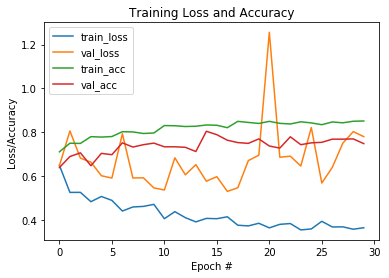

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# plot the training loss and accuracy
def plotResults(): 
    plt.figure()
    N = epochs
    
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")

    # make the graph understandable: 
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    plt.show()
    
plotResults()

After ~10 epochs the neural network reaches ~75% accuracy. We can witness overfitting, no progress is made over validation set in the next epochs.

## Data augmentation

Let's take the image of the cat again: 


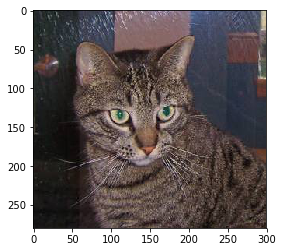

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = load_img('./data/train/cats/cat.1.jpg')  

# Show the image: 
imgplot = plt.imshow(img)
plt.show()

We will be performing data augmentation so that our CNN will work more robustly. 

Keras offers us a preprocessing library. This allows us a number of operations, including: 

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

More options available in the documentation: http://keras.io/preprocessing/image/

Let's demonstrate this on the cat image: 

In [10]:
# change the characteristics to augment the data in different way if you want to explore... 
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('./data/train/cats/cat.1.jpg')  

# reshape the image to a numpy array
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) 
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
# this will execute the flow function 20 times. 
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='cat', save_format='jpg'):
    i += 1
    if i > 19:
        break  # otherwise the generator would loop indefinitely

This has put the images in our preview/ folder. You can check in your filemanager or via: 

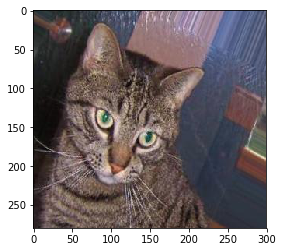

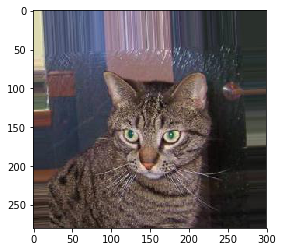

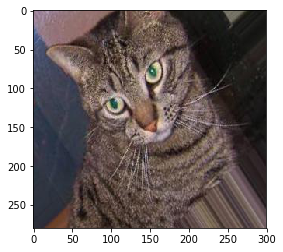

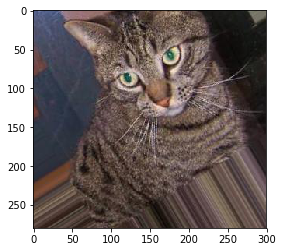

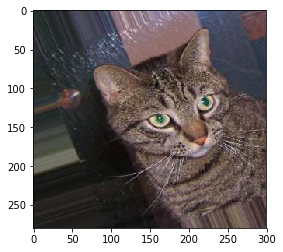

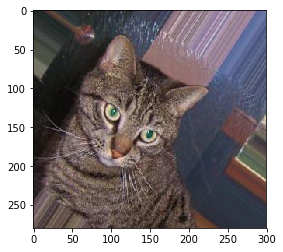

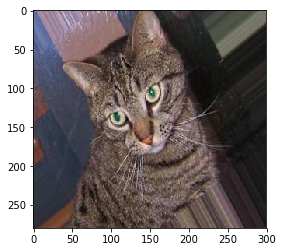

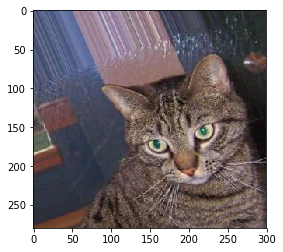

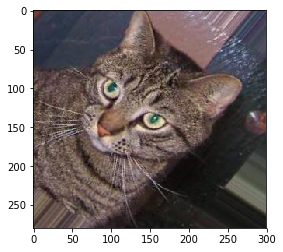

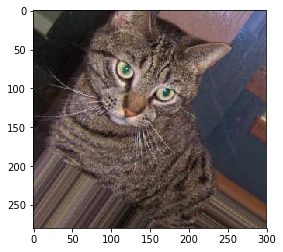

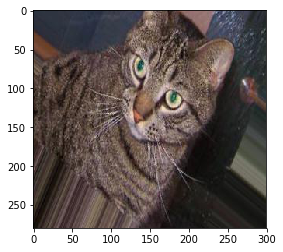

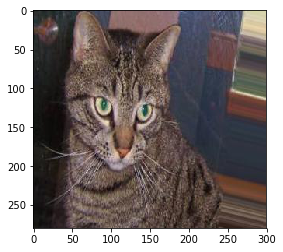

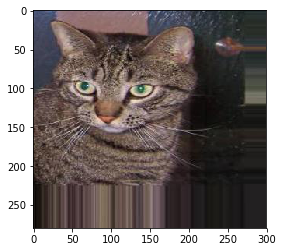

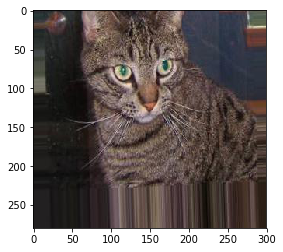

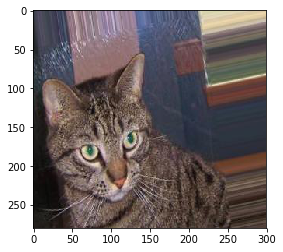

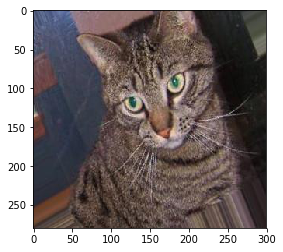

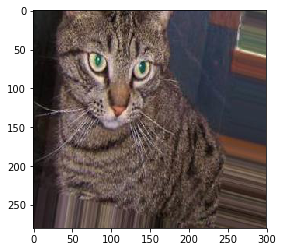

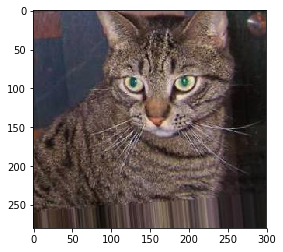

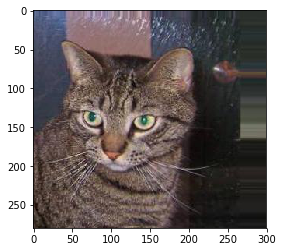

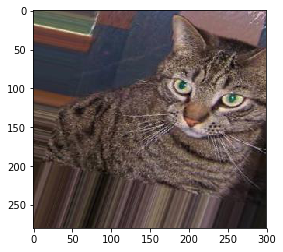

In [11]:
from PIL import Image
import glob
for filename in glob.glob('preview/*.jpg'): 
    img=Image.open(filename)
    imgplot = plt.imshow(img)
    plt.show()
    

Great! Notice how the cat images are mirrored, skewed and generally deformed. This will allow our model to train more robustly. 

Time to setup the model with Keras. We will be downscaling all the images to 150x150 pixels so that they are all the same size. We will try a 3 layered model with ReLu nodes and pooling. 

Now we can integrate this in our previous data preprocessing as follows: 

In [12]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


Train the model: 

In [15]:
history = History()  # this will allow us to plot the evolution of the validation loss after training

model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[history],  # save the history so that we can plot it later
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/30
64/64 [==============================] - 21s 328ms/step - loss: 0.6471 - acc: 0.7109 - val_loss: 0.6471 - val_acc: 0.6382
Epoch 2/30
64/64 [==============================] - 20s 317ms/step - loss: 0.5271 - acc: 0.7481 - val_loss: 0.8057 - val_acc: 0.6887
Epoch 3/30
64/64 [==============================] - 20s 306ms/step - loss: 0.5257 - acc: 0.7476 - val_loss: 0.6813 - val_acc: 0.7055
Epoch 4/30
64/64 [==============================] - 22s 345ms/step - loss: 0.4826 - acc: 0.7788 - val_loss: 0.6629 - val_acc: 0.6466
Epoch 5/30
64/64 [==============================] - 20s 310ms/step - loss: 0.5067 - acc: 0.7764 - val_loss: 0.6009 - val_acc: 0.7031
Epoch 6/30
64/64 [==============================] - 20s 309ms/step - loss: 0.4882 - acc: 0.7803 - val_loss: 0.5903 - val_acc: 0.6971
Epoch 7/30
64/64 [==============================] - 20s 319ms/step - loss: 0.4389 - acc: 0.8032 - val_loss: 0.7928 - val_acc: 0.7512
Epoch 8/30
64/64 [==============================] - 20s 311ms/step - 

Saving the trained model: 

In [16]:
model.save_weights('augmented_30_epochs.h5')

How does this model perform? 

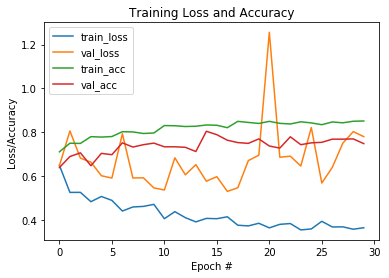

In [19]:
plotResults()

Excellent, you have trained a CNN with augmented data! The accuracy is much higher and surpasses 80%

Now let's see if we can use this model to get the class prediction for one particular image: 

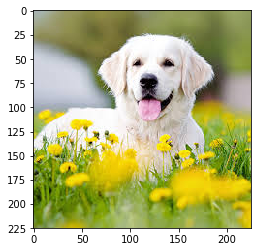

In [20]:
import cv2

# Is this a dog or a cat? 
img = load_img('./data/test/test.jpg')  # this is a PIL image
imgplot = plt.imshow(img)
plt.show()

Now let's predict the class this image belongs to: 

In [21]:
testimg = cv2.imread('data/test/test.jpg')
testimg = cv2.resize(testimg,(150,150))

# data preprocessing to get the input in the same shape
x = img_to_array(testimg)  # this is a Numpy array with shape (3, x, y) 
x = x * 1./255
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, x, y)


predictedclass = model.predict_classes(x)

# cats are class 0; dogs are class 1 as you can see from command below
# print(train_generator.class_indices)

# making the output a bit nicer. 
if predictedclass == 1:
    prediction = 'dog'
else:
    prediction = 'cat'

print("This image is a "+ prediction + ".")
print(model.predict_proba(x))

This image is a dog.
[[0.99973613]]


It worked! Do you have a picture of your pet? Give it a go and see if your model can predict..

Note: if you did not train your model very long, it won't be accurate. For real applications, you may want to try a pretrained model (see below). .

## Advanced (optional and FYI)

Some very accurate image recognition models have been built based on a lot of data. It will often improve your results if you start from a saved pretrained model and further train the top of the model on your data. 

The below code is meant as an example of how you may do this. It's not part of the original lab. 

It is based on the pretrained model available at https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 (no need to download, the script will automatically fetch the data for you. 

The module architecture of the model we are loading is as follows: 
![alt text](https://blog.keras.io/img/imgclf/vgg16_modified.png "Title")


The VGG16 model is available in Keras: 

In [0]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 2s 0us/step


Using VGG16 to classify images: 

In [0]:
batch_size = 20

train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


This is a long process, so we save the output of the VGG16 once and for all.

In [0]:
train_samples = 2000
validation_samples = 800

bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [0]:
bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

Now we can load it...

In [0]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

And define and train the custom fully connected neural network :

In [0]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model_top.fit(train_data, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[history],  # save the history so that we can plot it later
        validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 7.9649 - acc: 0.4985 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 7.9632 - acc: 0.5005 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 7.9698 - acc: 0.5000 - val_loss: 7.8923 - val_acc: 0.5050
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 4.4765 - acc: 0.7060 - val_loss: 2.9450 - val_acc: 0.8075
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 3.2312 - acc: 0.7870 - val_loss: 3.5839 - val_acc: 0.7675
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 2.8761 - acc: 0.8145 - val_loss: 2.3776 - val_acc: 0.8462
Epoch 8/30
2000

The training process of this small neural network is very fast : ~3s per epoch

In [0]:
model_top.save_weights('bottleneck_30_epochs.h5')

Let's evaluate this model. Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs : 

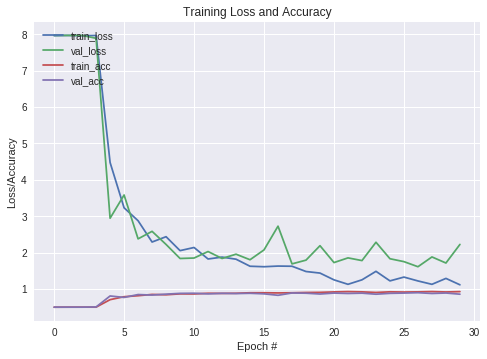

In [0]:
plotResults()

**We reached 90-95% accuracy on the validation after ~1m of training (~20 epochs) and using only 8% of the samples originally available on the Kaggle competition!**

## References
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* https://blog.keras.io/img/imgclf/
<!--https://github.com/rajshah4/image_keras/blob/master/notebook.ipynb-->
